# 实验准备

In [1]:
import numpy as np
from mlxtend.data import loadlocal_mnist
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
# 如果计算机安装有CUDA，则使用CUDA进行接下来的全部训练，否则使用CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [3]:
class MnistDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# 加载数据集
train_images_path = '../data/train-images.idx3-ubyte'
train_labels_path = '../data/train-labels.idx1-ubyte'
test_images_path = '../data/t10k-images.idx3-ubyte'
test_labels_path = '../data/t10k-labels.idx1-ubyte'

# 读取训练数据
X_train, y_train = loadlocal_mnist(
    images_path=train_images_path,
    labels_path=train_labels_path)
# 调整图像形状
X_train = X_train.reshape(-1, 28, 28, 1)

# 将训练数据划分为训练集和验证集，固定划分（8:2）
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 读取测试数据，即测试集
X_test, y_test = loadlocal_mnist(
    images_path=test_images_path,
    labels_path=test_labels_path)
# 调整图像形状
X_test = X_test.reshape(-1, 28, 28, 1)

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

# 将训练集、验证集、测试集分别包装为Dataloader
transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

train_dataset = MnistDataset(X_train, y_train, transform=transform)
val_dataset = MnistDataset(X_val, y_val, transform=transform)
test_dataset = MnistDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

X_train:  (48000, 28, 28, 1)
y_train:  (48000,)
X_val:  (12000, 28, 28, 1)
y_val:  (12000,)
X_test:  (10000, 28, 28, 1)
y_test:  (10000,)


# 寻找最佳超参数组合

In [4]:
# 检查模型准确率（使用验证集或测试集）
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc

In [5]:
# 训练分类器
def train_classifier(model, optimizer, epochs):
    model = model.to(device=device)
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # 将待更新参数的梯度置为零
            optimizer.zero_grad()

            # 反向传播，计算梯度
            loss.backward()

            # 利用梯度更新参数
            optimizer.step()
            
    acc = check_accuracy(val_loader, model)
    return acc

In [6]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10, dropout=0.0):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        self.relu3 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.flatten(x)
        x = self.dropout1(x)  # 添加Dropout层
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout2(x)  # 添加Dropout层
        x = self.fc2(x)
        return x

In [19]:
# SGD as optimizer
best_model = None
best_val_acc = -1
best_lr = -1
best_momentum = -1

opt = "SGD"
learning_rates = [4e-3, 6e-3, 8e-3, 9.5e-3, 1.5e-2]
momentums = [0.9, 0.95]
weight_decay = 0.0001
dropout = 0.0

for lr in learning_rates:
    for momentum in momentums:
        model = LeNet(dropout=dropout)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=weight_decay)
        val_acc = train_classifier(model, optimizer, epochs=10)
        if val_acc > best_val_acc:
            best_model = model
            best_val_acc = val_acc
            best_lr = lr
            best_momentum = momentum
        print('optimizer %s lr %e momentum %e weight_decay %e val accuracy: %f' % (opt, lr, momentum, weight_decay, val_acc))
            
print('best validation accuracy achieved:')
print('optimizer %s lr %e momentum %e weight_decay %e val accuracy: %f' % (opt, best_lr, best_momentum, weight_decay, best_val_acc))
# optimizer SGD lr 1.000000e-02 momentum 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.990083 test accuracy: 0.989800

optimizer SGD lr 4.000000e-03 momentum 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.988583
optimizer SGD lr 4.000000e-03 momentum 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.988833
optimizer SGD lr 6.000000e-03 momentum 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.987750
optimizer SGD lr 6.000000e-03 momentum 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.989833
optimizer SGD lr 8.000000e-03 momentum 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.986667
optimizer SGD lr 8.000000e-03 momentum 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.988667
optimizer SGD lr 9.500000e-03 momentum 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.988000
optimizer SGD lr 9.500000e-03 momentum 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.987417
optimizer SGD lr 1.500000e-02 momentum 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.985167
optimizer SGD lr 1.500000e-02 momentum 9.500000e-01 weight_decay 1.000000e-04 val accuracy:

In [21]:
# Adam as optimizer
best_model = None
best_val_acc = -1
best_lr = -1

opt = "Adam"
learning_rates = [4e-4, 6e-4, 8e-4, 9.5e-4, 1.5e-3, 3e-3]
weight_decay = 0.0001
dropout = 0.0

for lr in learning_rates:
    model = LeNet(dropout=dropout)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    val_acc = train_classifier(model, optimizer, epochs=10)
    if val_acc > best_val_acc:
        best_model = model
        best_val_acc = val_acc
        best_lr = lr
    print('optimizer %s lr %e weight_decay %e val accuracy: %f' % (opt, lr, weight_decay, val_acc))
            
print('best validation accuracy achieved:')
print('optimizer %s lr %e weight_decay %e val accuracy: %f' % (opt, best_lr, weight_decay, best_val_acc))
# optimizer Adam lr 1.500000e-03 weight_decay 1.000000e-04 val accuracy: 0.989667 test accuracy: 0.990900

optimizer Adam lr 4.000000e-04 weight_decay 1.000000e-04 val accuracy: 0.988417
optimizer Adam lr 6.000000e-04 weight_decay 1.000000e-04 val accuracy: 0.988250
optimizer Adam lr 8.000000e-04 weight_decay 1.000000e-04 val accuracy: 0.985417
optimizer Adam lr 9.500000e-04 weight_decay 1.000000e-04 val accuracy: 0.988667
optimizer Adam lr 1.500000e-03 weight_decay 1.000000e-04 val accuracy: 0.989667
optimizer Adam lr 3.000000e-03 weight_decay 1.000000e-04 val accuracy: 0.985667
best validation accuracy achieved:
optimizer Adam lr 1.500000e-03 weight_decay 1.000000e-04 val accuracy: 0.989667


In [23]:
# RMSprop as optimizer
best_model = None
best_val_acc = -1
best_lr = -1
best_lr_decay = -1

opt = "RMSprop"
learning_rates = [6e-4, 8e-4, 9.5e-4, 1.5e-3, 3e-3]
lr_decays = [0.9, 0.95]
weight_decay = 0.0001
dropout = 0.0

for lr in learning_rates:
    for lr_decay in lr_decays:
        model = LeNet(dropout=dropout)
        optimizer = optim.RMSprop(model.parameters(), lr=lr, alpha=lr_decay, weight_decay=weight_decay)
        val_acc = train_classifier(model, optimizer, epochs=10)
        if val_acc > best_val_acc:
            best_model = model
            best_val_acc = val_acc
            best_lr = lr
            best_lr_decay = lr_decay
        print('optimizer %s lr %e lr_decay %e weight_decay %e val accuracy: %f' % (opt, lr, lr_decay, weight_decay, val_acc))
            
print('best validation accuracy achieved:')
print('optimizer %s lr %e lr_decay %e weight_decay %e val accuracy: %f' % (opt, best_lr, best_lr_decay, weight_decay, best_val_acc))
# optimizer RMSprop lr 1.000000e-03 lr_decay 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.989250 test accuracy: 0.990200

optimizer RMSprop lr 6.000000e-04 lr_decay 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.989083
optimizer RMSprop lr 6.000000e-04 lr_decay 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.985583
optimizer RMSprop lr 8.000000e-04 lr_decay 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.984333
optimizer RMSprop lr 8.000000e-04 lr_decay 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.988417
optimizer RMSprop lr 9.500000e-04 lr_decay 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.987833
optimizer RMSprop lr 9.500000e-04 lr_decay 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.987750
optimizer RMSprop lr 1.500000e-03 lr_decay 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.986333
optimizer RMSprop lr 1.500000e-03 lr_decay 9.500000e-01 weight_decay 1.000000e-04 val accuracy: 0.988667
optimizer RMSprop lr 3.000000e-03 lr_decay 9.000000e-01 weight_decay 1.000000e-04 val accuracy: 0.981833
optimizer RMSprop lr 3.000000e-03 lr_decay 9.500000e-01

In [24]:
test_acc = check_accuracy(test_loader, best_model)
print('test accuracy: %f' % test_acc)

test accuracy: 0.990200


# 训练最佳模型

In [7]:
def check_accuracy_alt(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        res = 'Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc)
        return res

In [8]:
def evaluate_classifier_alt(model):
    classifier_type = "LeNet"
    optimizer_type = "Adam"

    path = '../evaluation/LeNet_evaluation.txt'
    with open(path, 'w') as f:
        # 使用验证集
        f.write(f"{classifier_type} with {optimizer_type} on validation set:\n")
        val_res = check_accuracy_alt(val_loader, model)
        f.write(val_res + '\n\n')
        # 使用测试集
        f.write(f"{classifier_type} with {optimizer_type} on test set:\n")
        test_res = check_accuracy_alt(test_loader, model)
        f.write(test_res)

In [9]:
def train_classifier_alt(model, optimizer, epochs):
    loss_values = []
    train_acc_values = []
    val_acc_values = []
    
    model = model.to(device=device)
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # 将待更新参数的梯度置为零
            optimizer.zero_grad()

            # 反向传播，计算梯度
            loss.backward()

            # 利用梯度更新参数
            optimizer.step()
            
        loss_values.append(loss)
        print("Epoch %d/%d:" % (e + 1, epochs))
        train_acc = check_accuracy(train_loader, model)
        train_acc_values.append(train_acc)
        val_acc = check_accuracy(val_loader, model)
        val_acc_values.append(val_acc)
        print("Train Accuracy: %f Validation Accuracy: %f" % (train_acc, val_acc))
        
    evaluate_classifier_alt(model)
        
    path = '../models/LeNet_classifier.pth'
    torch.save(model.state_dict(), path)
    
    return loss_values, train_acc_values, val_acc_values

In [10]:
lr = 1.5e-3
weight_decay = 0.0001
dropout = 0.0
epochs = 10

model = LeNet(dropout=dropout)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_values, train_acc_values, val_acc_values = train_classifier_alt(model, optimizer, epochs=epochs)

Epoch 1/10:
Train Accuracy: 0.977354 Validation Accuracy: 0.975917
Epoch 2/10:
Train Accuracy: 0.984938 Validation Accuracy: 0.980333
Epoch 3/10:
Train Accuracy: 0.988688 Validation Accuracy: 0.985083
Epoch 4/10:
Train Accuracy: 0.990125 Validation Accuracy: 0.985417
Epoch 5/10:
Train Accuracy: 0.990917 Validation Accuracy: 0.985750
Epoch 6/10:
Train Accuracy: 0.992833 Validation Accuracy: 0.986833
Epoch 7/10:
Train Accuracy: 0.994896 Validation Accuracy: 0.985500
Epoch 8/10:
Train Accuracy: 0.993208 Validation Accuracy: 0.987250
Epoch 9/10:
Train Accuracy: 0.993146 Validation Accuracy: 0.986583
Epoch 10/10:
Train Accuracy: 0.995958 Validation Accuracy: 0.988083


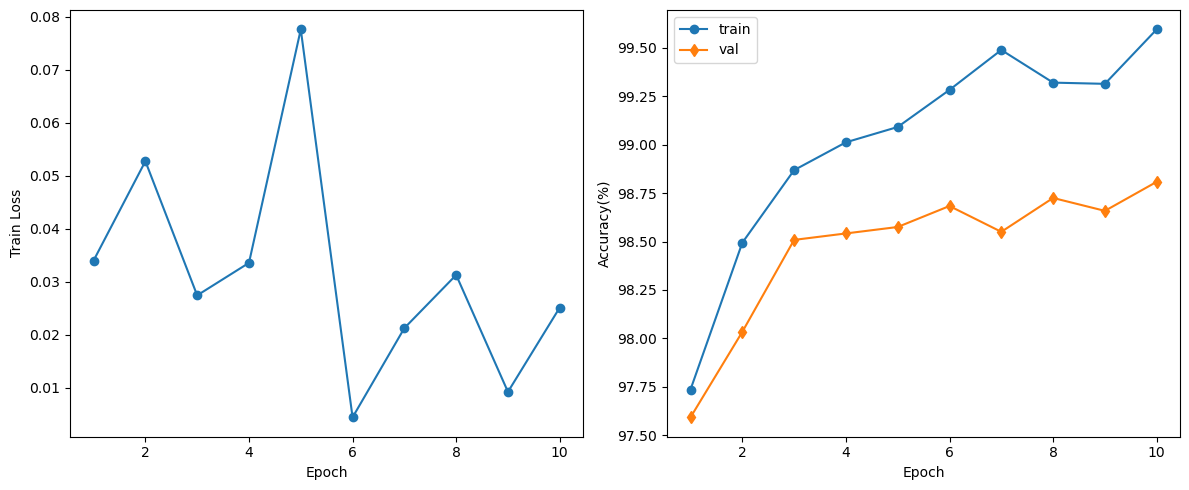

In [11]:
import matplotlib.pyplot as plt

fig_path = "../graph/LeNet loss and acc.png"

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
epochs = [i + 1 for i in range(epochs)]
loss_values = [tensor.cpu().detach().numpy() for tensor in loss_values]
train_acc_values = np.array(train_acc_values) * 100
val_acc_values = np.array(val_acc_values) * 100

# 损失
axs[0].plot(epochs, loss_values, marker='o')

axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Train Loss')

# 准确率
axs[1].plot(epochs, train_acc_values, label='train', marker='o')
axs[1].plot(epochs, val_acc_values, label='val', marker='d')

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy(%)')
axs[1].legend()

plt.tight_layout()
plt.savefig(fig_path)

In [12]:
def train_classifier_alt2(model, optimizer, epochs):
    model = model.to(device=device)
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # 将待更新参数的梯度置为零
            optimizer.zero_grad()

            # 反向传播，计算梯度
            loss.backward()

            # 利用梯度更新参数
            optimizer.step()
            
    val_acc = check_accuracy(val_loader, model)
    test_acc = check_accuracy(test_loader, model)
    
    return val_acc, test_acc

In [13]:
lr = 1.5e-3
weight_decay = 0.0001
dropout = 0.0
epochs = 10

val_acc_values = []
test_acc_values = []

for _ in range(10):
    model = LeNet(dropout=dropout)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    val_acc, test_acc = train_classifier_alt2(model, optimizer, epochs=epochs)
    val_acc_values.append(val_acc * 100)
    test_acc_values.append(test_acc * 100)
    
print("Validate: ", val_acc_values)
print("Test: ", test_acc_values)

Validate:  [98.84166666666667, 98.66666666666667, 98.95, 98.675, 98.75833333333334, 98.83333333333333, 98.98333333333333, 98.76666666666667, 98.16666666666667, 98.25]
Test:  [98.75, 98.9, 98.97, 98.71, 98.81, 99.0, 99.02, 98.92999999999999, 98.47, 98.48]
